In [1]:
import gc 
from typing import Tuple, Dict, List
from pathlib import Path
import numpy as np
import os
import sys


#from utils.helper import iterate_through_dir
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision.transforms.v2 as v2
import matplotlib.pyplot as plt
from PIL import Image
#from utils.datasetClass import xView2Dataset, image_transform, transform, collate_fn
import torchvision.models as models
from torchinfo import summary
import torch.nn as nn
import torch.nn.functional as F
#from utils.model import UNet_ResNet50, SiameseUnet, train_step, val_step
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torchmetrics.classification import MulticlassPrecision, MulticlassRecall, MulticlassF1Score
from torch.utils.tensorboard import SummaryWriter

from utils.dataset import transform, image_transform

KeyboardInterrupt: 

# Brief introduction in 
- contains a workflow for classification of building damage after natural desasters. 
- the xview2 dataset was used for more information see the README
- to detect the damage an image segmentation approach was used
- As a model a siamese neural network was chosen. It contains two UNets with ResNet50 encodern

# Define all Pathes and Variables

As a first step define all necessary pathes. The only name, that needs to be changes is the user name for the terrabyte.

The xView2 folder has the following structure:
/xview2
├── tier1/
│   ├── images/
│   ├── labels/
│   ├── png_images/
│   ├── targets/
├── tier3/
│   ├── images/
│   ├── labels/
│   ├── png_images/
│   ├── targets/
├── hold/
│   ├── images/
│   ├── labels/
│   ├── png_images/
│   ├── targets/
├── test/
│   ├── images/
│   ├── labels/
│   ├── png_images/
│   ├── targets/

In [ ]:
# HPC Terrabyte
# adapt the user to your needs
USER = "di97ren"
# keep the following unchanged
ROOT = Path("/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022")
USER_PATH = ROOT / f"users/{USER}"
DATA_PATH = ROOT / "data"


# Configure the path to the xview2 dataset for your environment
DATASET_ROOT = DATA_PATH / "xview2"

TRAIN_ROOT = DATASET_ROOT / "tier1"
TRAIN_IMG = TRAIN_ROOT / "png_images"
TRAIN_TARGET = TRAIN_ROOT / 'targets'

VAL_ROOT = DATASET_ROOT / "hold"
VAL_IMG = VAL_ROOT / "png_images"
VAL_TARGET = VAL_ROOT / 'targets'


TEST_ROOT = DATASET_ROOT / "test"
TEST_IMG = TEST_ROOT / "png_images"



# Pathes to store the experiment information in:
EXPERIMENT_GROUP = "xView2_Experiments"
EXPERIMENT_ID = "001"

EXPERIMENT_DIR = Path(f"/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/data/xview2/{EXPERIMENT_GROUP}")
EXPERIMENT_DIR.mkdir(parents=True, exist_ok=True)

CHECKPOINTS_DIR = EXPERIMENT_DIR / f"checkpoints/{EXPERIMENT_GROUP}"
CHECKPOINTS_DIR.mkdir(parents=True, exist_ok=True)
print(EXPERIMENT_DIR)

/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/data/xview2/xView2_Experiments


In [ ]:
from utils.helper_functions import iterate_through_dir


# Take a Look what is inside our ROOT Directory and how many files are inside the other folders:

iterate_through_dir(TRAIN_ROOT)
iterate_through_dir(VAL_ROOT)
iterate_through_dir(TEST_ROOT)

There are 4 directories and 0 images in '/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/data/xview2/tier1'.
There are 0 directories and 5596 images in '/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/data/xview2/tier1/labels'.
There are 0 directories and 5596 images in '/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/data/xview2/tier1/images'.
There are 0 directories and 5596 images in '/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/data/xview2/tier1/targets'.
There are 0 directories and 5596 images in '/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/data/xview2/tier1/png_images'.
There are 4 directories and 0 images in '/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/data/xview2/hold'.
There are 0 directories and 1866 images in '/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/data/xview2/hold/labels'.
There are 0 directories and 1866 images in '/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/data/xview2/hold/images'.
There are 0 directories and 1866 images in '/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/data/xview2/hold/targets'.
There are 0 directories and 

# Dataset Class and Collate Function

TODO- Explain the dataset class and collate function
TODO - Also Explain the image transform and transform function

In [ ]:
class xView2Dataset(Dataset):
    '''
    A custom PyTorch Dataset class designed for the xView2 dataset, supporting both training (with target masks)
    and inference (without masks).
    The dataset expects pre-disaster and post-disaster image pairs, 
    with optional corresponding target masks.
    '''
    def __init__(self,
                 png_path: str,
                 target_path: callable = None,
                 transform: callable = None,
                 image_transform: callable = None,
                 inference = False):

        
        self.png_path = png_path
        self.target_path = target_path
        self.transform = transform
        self.image_transform = image_transform
        self.inference = inference

        

        # get all pre-disaster images:
        self.pre_images = sorted(self.png_path.glob("*_pre_disaster.png"))
        
        self.pairs = [] #

        for pre_img_path in self.pre_images:
            post_img_path = self.png_path / pre_img_path.name.replace("_pre_disaster", "_post_disaster")

            if self.inference: 
                if post_img_path.exists():
                    self.pairs.append((pre_img_path, post_img_path))
            else: 
                # Nur im Trainingsmodus benötigen wir target_path
                if self.target_path is None:
                    raise ValueError("target_path must be provided when not in inference mode")
                    
                post_target_path = self.target_path / pre_img_path.name.replace("_pre_disaster", "_post_disaster")
                pre_target_path = self.target_path / pre_img_path.name

                if post_img_path.exists() and post_target_path.exists() and pre_target_path.exists():
                    self.pairs.append((pre_img_path, post_img_path, pre_target_path, post_target_path))

        assert len(self.pairs) > 0, "No matching image-pairs found!"

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, index):

        if self.inference:
            pre_img_path, post_img_path = self.pairs[index]

            # Load images
            pre_img = Image.open(pre_img_path).convert("RGB")
            post_img = Image.open(post_img_path).convert("RGB")

            # Convert to numpy arrays
            pre_img = np.array(pre_img, dtype=np.float32) / 255.0
            post_img = np.array(post_img, dtype=np.float32) / 255.0

            # Convert to Tensor
            pre_img = torch.tensor(pre_img).permute(2, 0, 1)  # (H, W, C) → (C, H, W)
            post_img = torch.tensor(post_img).permute(2, 0, 1)
            
            if self.image_transform:
                pre_img = self.image_transform(pre_img)
                post_img = self.image_transform(post_img)

            return pre_img, post_img, pre_img_path.name, post_img_path.name

        else:
            pre_img_path, post_img_path, pre_target_path, post_target_path = self.pairs[index]

            # load images and target masks with 
            
            pre_img = Image.open(pre_img_path).convert("RGB")
            post_img = Image.open(post_img_path).convert("RGB")
            pre_target_mask = Image.open(pre_target_path).convert('L')
            post_target_mask = Image.open(post_target_path).convert('L')

            # convert to numpy arrays
            pre_img = np.array(pre_img, dtype=np.float32) / 255.0
            post_img = np.array(post_img, dtype=np.float32) / 255.0
            pre_target_mask = np.array(pre_target_mask, dtype=np.float32)
            post_target_mask = np.array(post_target_mask, dtype=np.float32)

            # convert to Tensor
            pre_img = torch.tensor(pre_img).permute(2, 0, 1)  # (H, W, C) → (C, H, W)
            post_img = torch.tensor(post_img).permute(2, 0, 1)
            pre_target_mask = torch.tensor(pre_target_mask).unsqueeze(0)  # (H, W) → (1, H, W)
            post_target_mask = torch.tensor(post_target_mask).unsqueeze(0)

            # Transformation (optional)
            if self.transform:
                stack = torch.cat([pre_img, post_img, pre_target_mask, post_target_mask], dim=0)  # (8, H, W)
                stack = self.transform(stack)

                pre_img, post_img, pre_target_mask, post_target_mask = stack[:3], stack[3:6], stack[6:7], stack[7:8]
            
            if self.image_transform:
                # Nur auf Bilder Normalisierung anwenden
                pre_img = self.image_transform(pre_img)
                post_img = self.image_transform(post_img)

            return pre_img, post_img, pre_target_mask, post_target_mask 
    
def collate_fn_test(batch):
    pre_imgs, post_imgs, pre_names, post_names = zip(*batch)
    # Stapeln der Tensoren entlang der Batch-Dimension (erste Dimension)
    pre_imgs = torch.stack(pre_imgs, dim=0)
    post_imgs = torch.stack(post_imgs, dim=0)

    return pre_imgs, post_imgs, pre_names, post_names

## Take a look at the Dataset and it structures:


In [ ]:
train_dataset = xView2Dataset(png_path = TRAIN_IMG,
                 target_path = TRAIN_TARGET,
                 transform = transform(),
                 image_transform = image_transform()
                 )

val_dataset = xView2Dataset(png_path = VAL_IMG ,
                 target_path = VAL_TARGET,
                 transform = transform(),
                 image_transform = image_transform()
                 )

train_dataset, val_dataset
len(train_dataset), len(val_dataset)

(2798, 933)

In [ ]:
# TODO - Inspect the dataset sample - show formats, length, masks
# TODO - Plot one image  

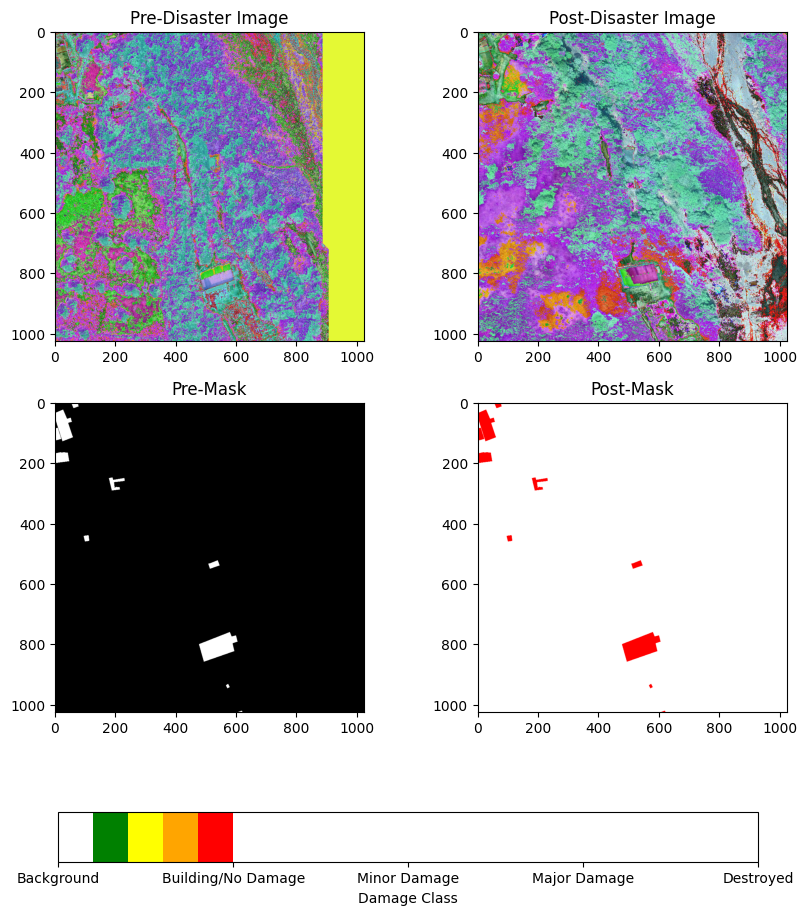

In [ ]:
from utils.viz import create_Control_plots

create_Control_plots(train_dataset[0]) # Inspect the first sample - Keep in mind, that the images are already transformed

# Model design
TODO: Overview (maybe a diagram)
TODO: Why did i choose the Siamese UNet and Why the ResNet50 (compare before and after images, and strong feature extraction of ResNet50)

In [ ]:
class UNet_ResNet50(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Load ResNet50 als Encoder
        resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        
        # Encoder-Pfad
        self.encoder = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4
        )
        
        # Decoder mit progressivem Upsampling
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 64, kernel_size=2, stride=2),
            nn.ReLU()
        )
        
        # Finale Klassifikationsschicht
        self.final_conv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Speichere Ursprungsgröße
        original_size = x.shape[2:]
        
        try:
            # Encoder-Durchgang
            features = self.encoder(x)
            #print(f"Encoder Output Shape: {features.shape}")

            # Decoder-Durchgang
            decoder_out = self.decoder(features)
            #print(f"Decoder Output Shape: {decoder_out.shape}")

            # Finale Konvolution
            out = self.final_conv(decoder_out)
            #print(f"Final Conv Output Shape: {out.shape}")

            # Upsample auf Originalgröße
            out = F.interpolate(out, size=original_size, mode='bilinear', align_corners=False)
            #print(f"Final Interpolated Output Shape: {out.shape}")

            return out

        except Exception as e:
            print(f"Error in forward pass: {e}")
            raise


In [ ]:
class SiameseUnet(nn.Module):
    def __init__(self, num_pre_classes=2, num_post_classes=6):
        super(SiameseUnet, self).__init__()

        self.unet_preDisaster = UNet_ResNet50(n_class=num_pre_classes)
        self.unet_postDisaster = UNet_ResNet50(n_class=num_post_classes)

        # Fusion-Layer kombiniert prä- und post-Klassifikationen
        self.fusion_layer = nn.Sequential(
            nn.Conv2d(num_pre_classes + num_post_classes, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, num_pre_classes + num_post_classes, kernel_size=1)
        )

    def forward(self, pre_image, post_image):
        pre_output = self.unet_preDisaster(pre_image)
        post_output = self.unet_postDisaster(post_image)

        # Konkatenieren der Ausgaben
        fused_output = torch.cat([pre_output, post_output], dim=1)

        # Fusion der Features
        final_output = self.fusion_layer(fused_output)

        return final_output

# Dealing with class imbalance
TODO Describe the problem: class imbalance in segmentation.

TODO How your custom loss handles it.

TODO Maybe show formulas or pseudo-code.

TODO If you created extra helper functions (like weighted cross-entropy, focal loss, etc.), you can explain them here too.

## Focal Loss

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        # Stelle sicher, dass alpha den richtigen Typ hat
        if alpha is not None:
            self.alpha = alpha.float() if isinstance(alpha, torch.Tensor) else torch.tensor(alpha, dtype=torch.float32)
        else:
            self.alpha = None
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Stelle sicher, dass die Eingaben den richtigen Typ haben
        inputs = inputs.float()  # Wandle in float32 um
        targets = targets.long()  # Wandle in long um
        
        B, C, H, W = inputs.size()
        
        # Reshape inputs and targets
        inputs = inputs.permute(0, 2, 3, 1).contiguous().view(-1, C)
        targets = targets.view(-1)
        
        # Stelle sicher, dass alpha zu float konvertiert wird und auf demselben Gerät liegt
        weight = None
        if self.alpha is not None:
            weight = self.alpha.to(inputs.device).float()
        
        # Berechne Cross-Entropy-Loss
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=weight)
        
        # Berechne Wahrscheinlichkeiten
        probs = F.softmax(inputs, dim=1)
        probs_t = probs.gather(1, targets.unsqueeze(1)).squeeze(1)
        
        # Wende Focal-Gewichtung an
        focal_weight = (1 - probs_t) ** self.gamma
        focal_loss = focal_weight * ce_loss
        
        # Wende reduction an
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:  # 'none'
            return focal_loss


In [ ]:

# Combined loss function for training
def combined_loss_function(outputs, pre_masks, post_masks):
    pre_outputs = outputs[:, :2]  # First 2 channels
    post_outputs = outputs[:, 2:]  # Remaining channels
    
    # Calculate focal losses
    pre_loss = focal_loss_pre(pre_outputs, pre_masks)
    post_loss = focal_loss_post(post_outputs, post_masks)
    
    # Combine losses (you can adjust weights)
    total_loss = pre_loss + post_loss
    return total_loss

## Load the weights and class counts
TODO 
ACHTUNG EINMAL DIESEN TEIL HIER DURCHLAUFEN LASSEN UND SPEICHERN - SO KANN ICH DANN DAS MODELL EINMALIG LADEN:   

In [ ]:
from utils.training_preparations import (calculate_class_counts, save_class_counts, load_class_counts, get_sample_weights, save_sample_weights, load_sample_weights)
import json
# Basis-Ordner (geht hoch aus notebooks/)
base_dir = os.path.dirname(os.path.dirname(os.path.abspath(__file__))) if "__file__" in globals() else os.path.abspath("../")

# Korrekte Pfade
class_counts_path = os.path.join(base_dir, "precalculations", "class_counts.json")
sample_weights_path = os.path.join(base_dir, "precalculations", "sample_weights.pt")

# Wenn die Datei existiert, laden, sonst berechnen
if os.path.exists(class_counts_path):
    print("Lade gespeicherte Class Counts...")
    pre_counts, post_counts = load_class_counts(class_counts_path)
else:
    print("Berechne Class Counts...")
    pre_counts, post_counts = calculate_class_counts(train_dataset)
    save_class_counts(pre_counts, post_counts, class_counts_path)

if os.path.exists(sample_weights_path):
    print("Lade gespeicherte Sample Weights...")
    sample_weights = load_sample_weights(sample_weights_path)
else:
    print("Berechne Sample Weights...")
    sample_weights = get_sample_weights(train_dataset)
    save_sample_weights(sample_weights, sample_weights_path)


Berechne Class Counts...


Berechne Klassenverteilung:   1%|          | 16/2798 [00:02<06:02,  7.67it/s]

In [ ]:
from torchmetrics import MulticlassJaccardIndex

# Updated train_step function
def train_step(model, dataloader, optimizer, epoch):

    
    model.train()
    train_loss = 0.0
    
    precision_pre = MulticlassPrecision(num_classes=2).to(device)
    recall_pre = MulticlassRecall(num_classes=2).to(device)
    f1_pre = MulticlassF1Score(num_classes=2).to(device)
    iou_pre = MulticlassJaccardIndex(num_classes=2, average='macro').to(device)

    precision_post = MulticlassPrecision(num_classes=6).to(device)
    recall_post = MulticlassRecall(num_classes=6).to(device)
    f1_post = MulticlassF1Score(num_classes=6).to(device)
    iou_post = MulticlassJaccardIndex(num_classes=6, average='macro').to(device)


    for pre_imgs, post_imgs, pre_masks, post_masks in dataloader:
        X_pre = pre_imgs.to(device)
        y_pre = pre_masks.to(device)
        X_post = post_imgs.to(device)
        y_post = post_masks.to(device)
        X_pre = X_pre.float()
        X_post = X_post.float()
        # Prepare masks for metrics
        y_pre_metric = y_pre.squeeze(1).long()
        y_post_metric = y_post.squeeze(1).long()

        # Forward pass
        pred = model(X_pre, X_post)
        pred.float()
        # Calculate loss using combined loss function
        loss = combined_loss_function(pred, y_pre_metric, y_post_metric)
        
        # Backward pass and optimize
        # optimizer.zero_grad()
        # loss.backward()
        # optimizer.step()
        
        optimizer.zero_grad()
        loss.backward()

                # Im train_step nach loss.backward()
        for name, param in model.named_parameters():
            if param.grad is not None:
                writer.add_histogram(f"gradients/{name}", param.grad, epoch)
                writer.add_histogram(f"weights/{name}", param, epoch)

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        # Track loss
        train_loss += loss.item()
        
        # Get predictions
        pre_pred = torch.argmax(pred[:, :2], dim=1)
        post_pred = torch.argmax(pred[:, 2:], dim=1)
        
        # Update metrics
        precision_pre.update(pred[:, :2], y_pre_metric)
        recall_pre.update(pred[:, :2], y_pre_metric)
        f1_pre.update(pred[:, :2], y_pre_metric)
        iou_pre.update(pred[:, :2], y_pre_metric)

        precision_post.update(pred[:, 2:], y_post_metric)
        recall_post.update(pred[:, 2:], y_post_metric)
        f1_post.update(pred[:, 2:], y_post_metric)
        iou_post.update(pred[:, 2:], y_post_metric)

    # Calculate average metrics
    avg_train_loss = train_loss / len(dataloader)
    
    precision_pre_value = precision_pre.compute()
    recall_pre_value = recall_pre.compute()
    f1_pre_value = f1_pre.compute()
    mean_iou_pre = iou_pre.compute()

    precision_post_value = precision_post.compute()
    recall_post_value = recall_post.compute()
    f1_post_value = f1_post.compute()
    mean_iou_post = iou_post.compute()

    # # Calculate average IoU
    # avg_iou_pre = {cls: val / sample_count for cls, val in iou_pre.items()}
    # avg_iou_post = {cls: val / sample_count for cls, val in iou_post.items()}
    # mean_iou_pre = sum(avg_iou_pre.values()) / len(avg_iou_pre)
    # mean_iou_post = sum(avg_iou_post.values()) / len(avg_iou_post)
    
    # TensorBoard Logging
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)
    
    # Logging for pre-disaster metrics
    writer.add_scalar("Precision_Pre/Train", precision_pre_value.mean(), epoch)
    writer.add_scalar("Recall_Pre/Train", recall_pre_value.mean(), epoch)
    writer.add_scalar("F1_Score_Pre/Train", f1_pre_value.mean(), epoch)
    writer.add_scalar("IoU_Pre/Train", mean_iou_pre, epoch)
    
    
    # Logging for post-disaster metrics
    writer.add_scalar("Precision_Post/Train", precision_post_value.mean(), epoch)
    writer.add_scalar("Recall_Post/Train", recall_post_value.mean(), epoch)
    writer.add_scalar("F1_Score_Post/Train", f1_post_value.mean(), epoch)
    writer.add_scalar("IoU_Post/Train", mean_iou_post, epoch)
    

    return avg_train_loss


In [ ]:

# Updated val_step function
def val_step(model, dataloader, epoch):
    model.eval()
    val_loss = 0.0
    
    precision_pre = MulticlassPrecision(num_classes=2).to(device)
    recall_pre = MulticlassRecall(num_classes=2).to(device)
    f1_pre = MulticlassF1Score(num_classes=2).to(device)
    iou_pre = MulticlassJaccardIndex(num_classes=2, average='macro').to(device)
    precision_post = MulticlassPrecision(num_classes=6).to(device)
    recall_post = MulticlassRecall(num_classes=6).to(device)
    f1_post = MulticlassF1Score(num_classes=6).to(device)
    iou_post = MulticlassJaccardIndex(num_classes=6, average='macro').to(device)

    with torch.no_grad():
        for pre_imgs, post_imgs, pre_masks, post_masks in dataloader:
            X_pre = pre_imgs.to(device)
            y_pre = pre_masks.to(device)
            X_post = post_imgs.to(device)
            y_post = post_masks.to(device)

                        # Convert tensors to float32
            X_pre = X_pre.float()
            X_post = X_post.float()

            
            # Prepare masks for metrics
            y_pre_metric = y_pre.squeeze(1).long()
            y_post_metric = y_post.squeeze(1).long()
            
            # Forward pass
            pred = model(X_pre, X_post)
            pred= pred.float()
            # Calculate loss using combined loss function
            loss = combined_loss_function(pred, y_pre_metric, y_post_metric)
            val_loss += loss.item()
            
            # Get predictions
            pre_pred = torch.argmax(pred[:, :2], dim=1)
            post_pred = torch.argmax(pred[:, 2:], dim=1)
            
            # Update metrics
            precision_pre.update(pred[:, :2], y_pre_metric)
            recall_pre.update(pred[:, :2], y_pre_metric)
            f1_pre.update(pred[:, :2], y_pre_metric)
            iou_pre.update(pred[:, :2], y_pre_metric)

            precision_post.update(pred[:, 2:], y_post_metric)
            recall_post.update(pred[:, 2:], y_post_metric)
            f1_post.update(pred[:, 2:], y_post_metric)
            iou_post.update(pred[:, :2], y_post_metric)

            # Calculate IoU for each class
            batch_size = y_pre.size(0)
            sample_count += batch_size

         
            # for b in range(batch_size):
            #     # Pre-disaster IoU
            #     for cls in [0, 1]:
            #         iou_pre[cls] += calculate_iou(pre_pred[b].cpu(), y_pre_metric[b].cpu(), cls)
                
            #     # Post-disaster IoU
            #     for cls in range(6):
            #         iou_post[cls] += calculate_iou(post_pred[b].cpu(), y_post_metric[b].cpu(), cls)
    
    # Calculate average metrics
    avg_val_loss = val_loss / len(dataloader)
    
    precision_pre_value = precision_pre.compute().cpu().numpy()
    recall_pre_value = recall_pre.compute().cpu().numpy()
    f1_pre_value = f1_pre.compute().cpu().numpy()
    mean_iou_pre = iou_pre.compute()

    precision_post_value = precision_post.compute().cpu().numpy()
    recall_post_value = recall_post.compute().cpu().numpy()
    f1_post_value = f1_post.compute().cpu().numpy()
    mean_iou_post = iou_post.compute()
   
    
    # TensorBoard Logging
    writer.add_scalar("Loss/Val", avg_val_loss, epoch)
    
    # Logging for pre-disaster metrics
    writer.add_scalar("Precision_Pre/Val", precision_pre_value.mean(), epoch)
    writer.add_scalar("Recall_Pre/Val", recall_pre_value.mean(), epoch)
    writer.add_scalar("F1_Score_Pre/Val", f1_pre_value.mean(), epoch)
    writer.add_scalar("IoU_Pre/Val", mean_iou_pre, epoch)
    
    
    # Logging for post-disaster metrics
    writer.add_scalar("Precision_Post/Val", precision_post_value.mean(), epoch)
    writer.add_scalar("Recall_Post/Val", recall_post_value.mean(), epoch)
    writer.add_scalar("F1_Score_Post/Val", f1_post_value.mean(), epoch)
    writer.add_scalar("IoU_Post/Val", mean_iou_post, epoch)
    
    
    return avg_val_loss

In [ ]:
# Constants and Setup
NUM_CLASSES = 6
EPOCHS = 50


# Create focal loss instances with class weights
focal_loss_pre = FocalLoss(alpha=class_weights_pre, gamma=2)
focal_loss_post = FocalLoss(alpha=class_weights_post, gamma=2)


# At the beginning of your script
torch.set_default_tensor_type(torch.FloatTensor)
# Set up model
model = SiameseUnet(num_pre_classes=2, num_post_classes=6)
if torch.cuda.device_count() > 1:
    print(f"Verwende {torch.cuda.device_count()} GPUs!")
    model = torch.nn.DataParallel(model)
model = model.to(device)

# Set up tensorboard writer
writer = SummaryWriter(EXPERIMENT_DIR / EXPERIMENT_ID)
print(writer)
# Set up optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)  # Etwas niedrigere Startlernrate
scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,          # Längerer erster Zyklus
    T_mult=2,
    eta_min=1e-6
)


# DataLoader 

TODO: Explain Weighted Dataloader

In [ ]:


print("Create Train Dataloader")
# Create dataloaders
train_dataloader = create_weighted_dataloader(train_dataset, batch_size=32)
print("Done")

print("Create Validation Dataloader")
val_dataloader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=collate_fn,
    pin_memory=True
)



Inspect one Batch

In [ ]:
for pre_imgs, post_imgs, pre_masks, post_masks in train_dataloader:
    pre_imgs_np = pre_imgs.detach().cpu().numpy()
    print(f"Pre-Disaster Batch Shape: {pre_imgs_np.shape}")
    print(f"Pre-Disaster Batch dtype: {pre_imgs_np.dtype}")
    print(f"Min: {pre_imgs_np.min()}, Max: {pre_imgs_np.max()}")

    post_imgs_np = post_imgs.detach().cpu().numpy()
    print(f"Post-Disaster Batch Shape: {post_imgs_np.shape}")
    print(f"Pre-Disaster Batch dtype: {post_imgs_np.dtype}")
    print(f"Min: {post_imgs_np.min()}, Max: {post_imgs_np.max()}")
    break


In [ ]:
gc.collect()

Start Training

In [ ]:


# Training loop
best_val_loss = float('inf')
best_checkpoint_path = None
print("starting Training Loop")
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    
    # Training step
    avg_train_loss = train_step(model, train_dataloader, optimizer, epoch)
    print(f"Train Loss: {avg_train_loss:.4f}")
    
    # Validation step
    avg_val_loss = val_step(model, val_dataloader, epoch)
    print(f"Val Loss: {avg_val_loss:.4f}")
    
    # Update learning rate
    scheduler.step()
    
    # Save checkpoint if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_checkpoint_path = CHECKPOINTS_DIR / f'{EXPERIMENT_GROUP}_{EXPERIMENT_ID}_epoch_{epoch+1}.pth'
        
        print(f"Attempting to save checkpoint to {best_checkpoint_path}")
        print(f"Directory exists: {CHECKPOINTS_DIR.exists()}")
        print(f"Directory is writable: {os.access(CHECKPOINTS_DIR, os.W_OK)}")
        
        try:
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': best_val_loss,
            }, best_checkpoint_path)
            print(f'Successfully saved checkpoint at {best_checkpoint_path}')
            best_checkpoint_path_str = f"val_loss:{best_val_loss:.4f}@{best_checkpoint_path}"
            writer.add_text("Best Checkpoint Path", best_checkpoint_path_str, epoch)
        except Exception as e:
            print(f"Error saving checkpoint: {e}")
    
    # Log current learning rate
    writer.add_scalar("LR", scheduler.get_last_lr()[0], epoch)

writer.close()
print("Done!")

In [ ]:
# Save just the state dictionary (weights only)
torch.save(model.state_dict(), 'precalculations/siamese_unet_weights.pth')

gc.collect()

# Inference

In [ ]:

test_dataset = xView2Dataset(png_path= TEST_IMG,
                 image_transform = image_transform(),
                 inference = True)


test_dataloader = DataLoader(
    test_dataset,
    batch_size=64,  # Kann größer sein als beim Training
    collate_fn=collate_fn_test,
    shuffle=False,  # Bei Inference nicht shuffeln
    num_workers=5
)

In [ ]:
from utils.inferene import find_best_checkpoint, load_checkpoint


# Modell initialisieren
model = SiameseUnet(num_pre_classes=2, num_post_classes=6)
model.to(device)
device = "cuda" if torch.cuda.is_available() else "cpu"


# Besten Checkpoint laden
model = load_checkpoint(model, best_checkpoint_path)


## Define inference step

TODO: Entscheide dich, wo geplottet wird - in inference oder in gesonderter funktion

im viz ist eine funktion abgelegt

In [ ]:
def inference(model, dataloader):
    model.eval()
    
    results = {
        'pre_predictions': [],
        'post_predictions': [],
        'pre_names': [],
        'post_names': [],
        'pre_images': [],
        'post_images': []
    }
    
    total_samples = 0
    
    with torch.no_grad():
        for pre_imgs, post_imgs, pre_names, post_names in dataloader:
            pre_imgs = pre_imgs.to(device)
            post_imgs = post_imgs.to(device)
            
            # Forward pass
            outputs = model(pre_imgs, post_imgs)
            
            # Überprüfe die Form der Ausgabe
            print(f"Outputs shape: {outputs.shape}")
            
            # Trenne die Ausgaben für Pre- und Post-Disaster
            pre_outputs = outputs[:, :2]  # 2 Klassen für pre-disaster
            post_outputs = outputs[:, 2:]  # 6 Klassen für post-disaster
            
            # Detaillierte Logit-Statistiken
            print(f"Pre-outputs stats: min={pre_outputs.min().item():.4f}, max={pre_outputs.max().item():.4f}, mean={pre_outputs.mean().item():.4f}")
            print(f"Post-outputs stats: min={post_outputs.min().item():.4f}, max={post_outputs.max().item():.4f}, mean={post_outputs.mean().item():.4f}")
            
            # Schaue dir die erste Batch an
            for b in range(min(1, pre_outputs.shape[0])):
                print(f"Bild {b}:")
                for c in range(pre_outputs.shape[1]):
                    print(f"  Pre-Klasse {c}: min={pre_outputs[b,c].min().item():.4f}, max={pre_outputs[b,c].max().item():.4f}, mean={pre_outputs[b,c].mean().item():.4f}")
                for c in range(post_outputs.shape[1]):
                    print(f"  Post-Klasse {c}: min={post_outputs[b,c].min().item():.4f}, max={post_outputs[b,c].max().item():.4f}, mean={post_outputs[b,c].mean().item():.4f}")
            
            # Prüfe die Unterschiede zwischen den Logits an einem bestimmten Pixel
            sample_x, sample_y = 100, 100
            print(f"Sample at position ({sample_x},{sample_y}):")
            print(f"  Pre-logits: {pre_outputs[0, :, sample_x, sample_y]}")
            print(f"  Post-logits: {post_outputs[0, :, sample_x, sample_y]}")
            
            # Softmax anwenden
            pre_probs = torch.softmax(pre_outputs, dim=1)
            post_probs = torch.softmax(post_outputs, dim=1)
            
            # Prüfe die Wahrscheinlichkeiten am selben Pixel
            print(f"  Pre-probs: {pre_probs[0, :, sample_x, sample_y]}")
            print(f"  Post-probs: {post_probs[0, :, sample_x, sample_y]}")
            
            # Vorhersagen erstellen
            pre_pred = torch.argmax(pre_probs, dim=1).cpu().numpy()
            post_pred = torch.argmax(post_probs, dim=1).cpu().numpy()
            
            # Prüfe die Verteilung der Vorhersagen
            pre_classes, pre_counts = np.unique(pre_pred, return_counts=True)
            post_classes, post_counts = np.unique(post_pred, return_counts=True)
            
            print(f"Pre-disaster class distribution: {dict(zip(pre_classes, pre_counts))}")
            print(f"Post-disaster class distribution: {dict(zip(post_classes, post_counts))}")
            
            # Speichere Bilder für die Visualisierung
            pre_images_cpu = pre_imgs.cpu().numpy()
            post_images_cpu = post_imgs.cpu().numpy()
            
            # Speichere Ergebnisse
            results['pre_predictions'].extend(pre_pred)
            results['post_predictions'].extend(post_pred)
            results['pre_names'].extend(pre_names)
            results['post_names'].extend(post_names)
            results['pre_images'].extend(pre_images_cpu)
            results['post_images'].extend(post_images_cpu)
            
            total_samples += len(pre_names)
    
    # Leistungsmetriken (optional)
    results['performance'] = {
        'total_samples': total_samples
    }
    
    return results



In [ ]:
# Inferenz durchführen
results = inference(model, test_dataloader)
visualize_predictions(results, num_samples = 5, random_seed = None)